
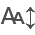

In [70]:
#!pip install itables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

# Analyzing 510(k) Submission Dataset

This is one of the first projects I completed in a Data Science cohort at FDA.  This cohort introducted participants to FDA's data science community and offered mentorship and practicle experience in Data Science in the public health sector.  Here are some notes to provide context on this project:

**What is a 510k submission?**
* A 510(k) is a premarket submission made to CDRH to demonstrate that the medical device to be marketed is substantially equivalent to a legally marketed device or a predicate device.​

* ​Through the 510(k) Program, the FDA conducts a comprehensive review of safety and performance data to determine if a new device is substantially equivalent to a device that is already on the market ​

* ​A device is substantially equivalent if, in comparison to a predicate it:​

* has the same intended use as the predicate; and​

* has the same technological characteristics as the predicate;​

​Or​

* has the same intended use as the predicate; and​

* has different technological characteristics and does not raise different questions of safety and effectiveness; and​

* the information submitted to FDA demonstrates that the device is as safe and effective as the legally marketed device.

more information on the data can be found here: https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfPMN/pmn.cfm

In [61]:
#Load dataset and make KNUMBER the index column

df510k = pd.read_csv(
    "Basecamp_combined_cleansed.csv",
    parse_dates=["DATERECEIVED", "DECISIONDATE"],
    index_col="KNUMBER",
    low_memory=False
)

# Randomly inspect 5 rows
print(df510k.sample(5))

                            APPLICANT                CONTACT  \
KNUMBER                                                        
K892800                  ZIMMER, INC.  WILLIAM  CHRISTIANSON   
K053203  RESPIRONICS NEW JERSEY, INC.        Lauren  Ziegler   
K083531          MEDLOGIC GLOBAL LTD.       TIERNEY  NORSTED   
K905600             TECHNALYSIS, INC.         STEPHEN C BIBY   
K071196                   COEUR, INC.        DEBRA F MANNING   

                               STREET1 STREET2         CITY STATE  \
KNUMBER                                                             
K892800                   P.O. BOX 708     NaN       WARSAW    IN   
K053203                41 CANFIELD RD.     NaN  CEDAR GROVE    NJ   
K083531  5353 WAYZATA BLVD., SUITE 505     NaN  MINNEAPOLIS    MN   
K905600            1805 RUTHERFORD LN.     NaN       AUSTIN    TX   
K071196                704 CADET COURT     NaN      LEBANON    TN   

        COUNTRY_CODE         ZIP POSTAL_CODE DECISION  ... STATEORS

* Examining the data set we see it contains 170, 287 records(rows) with 22 columns.  
* The columns detail Applicant info: KNUMBER, APPLICANT, CONTACT, CITY, STATE, etc.
* Application data: DECISION, REVIEWADVISECOMM, PRODUCTCODE, TYPE, DATERECEIVED, DECISIONDATE
* Device Details: DEVICENAME, CLASSADVISECOMM, THIRDPARTY, etc.


<center> <h2>Summarize the data for trends (e.g., counts by year, decision type).</h2> </center>

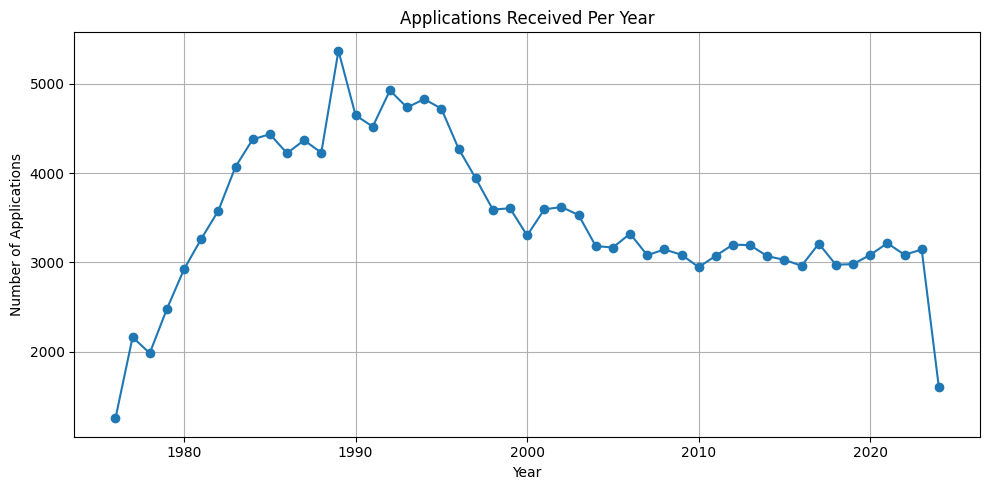

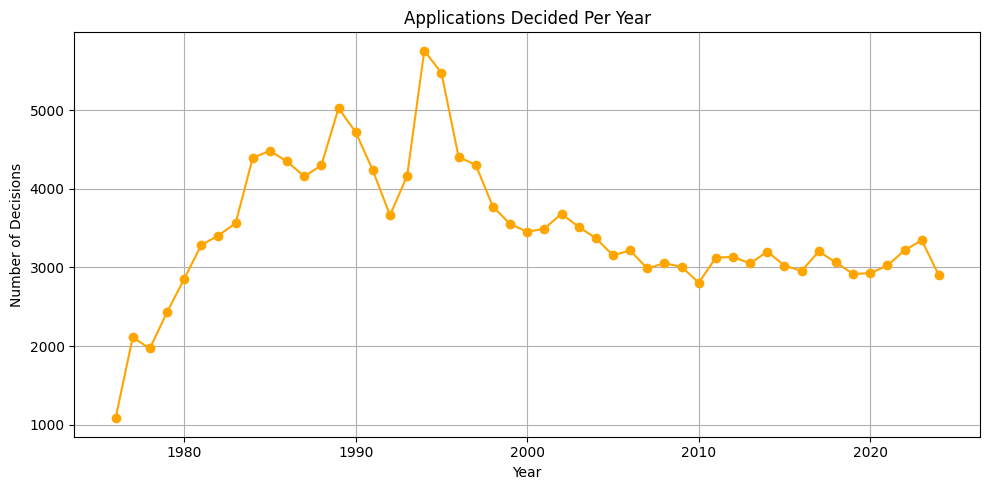

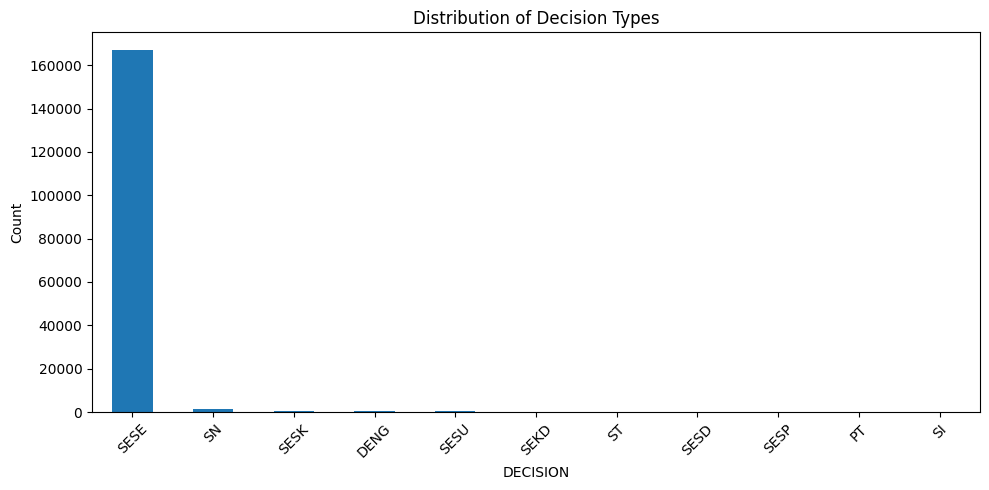

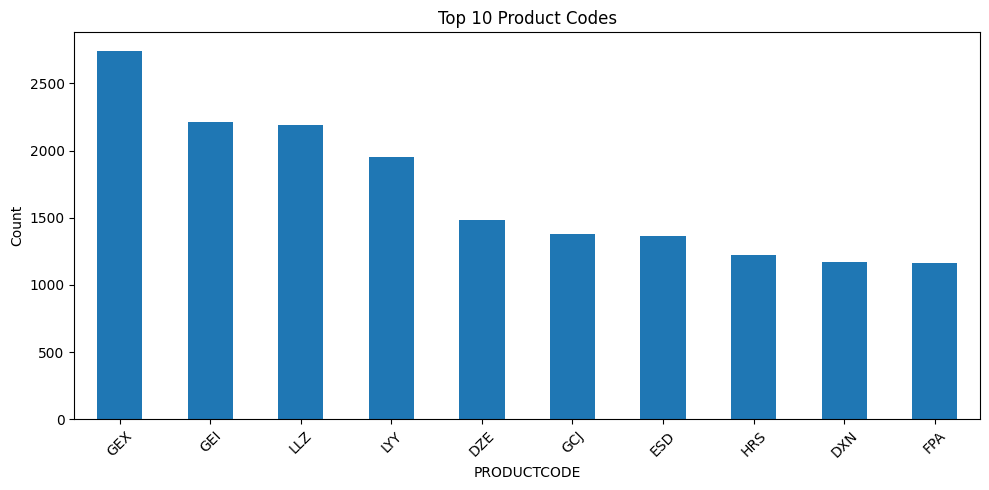

In [62]:
# Create year columns for trend analysis
df510k['YEAR_RECEIVED'] = df510k['DATERECEIVED'].dt.year
df510k['YEAR_DECIDED'] = df510k['DECISIONDATE'].dt.year

# Analyze trends: Number of applications received and decided per year
yearly_received = df510k['YEAR_RECEIVED'].value_counts().sort_index()
yearly_decided = df510k['YEAR_DECIDED'].value_counts().sort_index()

# Analyze distribution of decision types
decision_counts = df510k['DECISION'].value_counts()

# Analyze top 10 product codes
top_product_codes = df510k['PRODUCTCODE'].value_counts().head(10)

import matplotlib.pyplot as plt

# Plotting trends
plt.figure(figsize=(10, 5))
yearly_received.plot(kind='line', marker='o', title='Applications Received Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Applications')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
yearly_decided.plot(kind='line', marker='o', color='orange', title='Applications Decided Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Decisions')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting decisions
plt.figure(figsize=(10, 5))
decision_counts.plot(kind='bar', title='Distribution of Decision Types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting top product codes
plt.figure(figsize=(10, 5))
top_product_codes.plot(kind='bar', title='Top 10 Product Codes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Here's a summary of the trends and patterns identified:

**Applications Over Time:**

* The number of applications received and decided per year follows a relatively steady trend, with occasional peaks. This could correspond to regulatory shifts or industry innovations.

**Decision Distribution:**

* Certain decision types (e.g., “Substantially Equivalent”) dominate the dataset, suggesting most applications are cleared rather than rejected or withdrawn.

**Top Product Codes:**

* A few product codes appear far more frequently than others, indicating concentration in specific device types or categories.

<center> <h2> Identify correlations between variables such as decision time, device type, or class vs. decision outcomes</h2> </center>

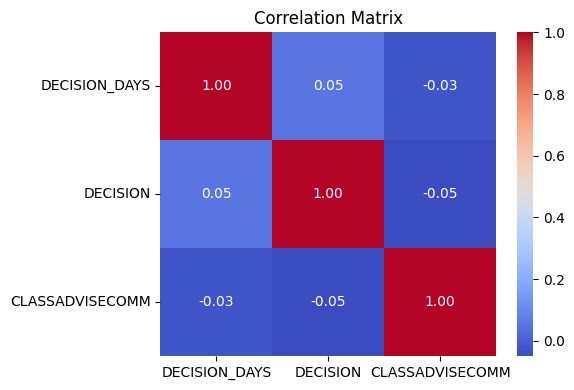

Decision Time Summary


In [63]:
# Calculate decision time in days
df510k['DECISION_DAYS'] = (df510k['DECISIONDATE'] - df510k['DATERECEIVED']).dt.days

# Select relevant columns for correlation
correlation_df = df510k[['DECISION_DAYS']].copy()

# Encode categorical variables numerically where possible
# For example, we can map common decision types and class advisory committees
decision_mapping = {k: i for i, k in enumerate(df510k['DECISION'].dropna().unique())}
class_mapping = {k: i for i, k in enumerate(df510k['CLASSADVISECOMM'].dropna().unique())}

correlation_df['DECISION'] = df510k['DECISION'].map(decision_mapping)
correlation_df['CLASSADVISECOMM'] = df510k['CLASSADVISECOMM'].map(class_mapping)

# Drop rows with any missing values in selected fields
correlation_df_clean = correlation_df.dropna()

# Compute correlation matrix
correlation_matrix = correlation_df_clean.corr()

# Plot heatmap of correlations
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Summary statistics for decision time by decision type
decision_time_summary = df510k.groupby('DECISION')['DECISION_DAYS'].describe()

import ace_tools_open as tools; tools.display_dataframe_to_user(name="Decision Time Summary", dataframe=decision_time_summary)


🔍 **Correlations**:
The correlation matrix showed weak relationships overall between DECISION_DAYS (processing time) and variables like DECISION or CLASSADVISECOMM. These categorical variables likely affect outcomes in more nuanced ways not captured by basic correlation.

⏱️ **Decision Time Insights**:
SESE (Substantially Equivalent - Standard) decisions are by far the most common, with an average processing time of ~116 days.

DENG decisions (likely denials) take considerably longer on average (~340 days).

SESD (Substantially Equivalent - Special) decisions are processed much faster, around 103 days on average.

There's substantial variability (standard deviations are large), suggesting some cases take much longer depending on context.

*This implies that the type of decision has a clear impact on review duration, even if linear correlation is weak.*

## Explore further by product code

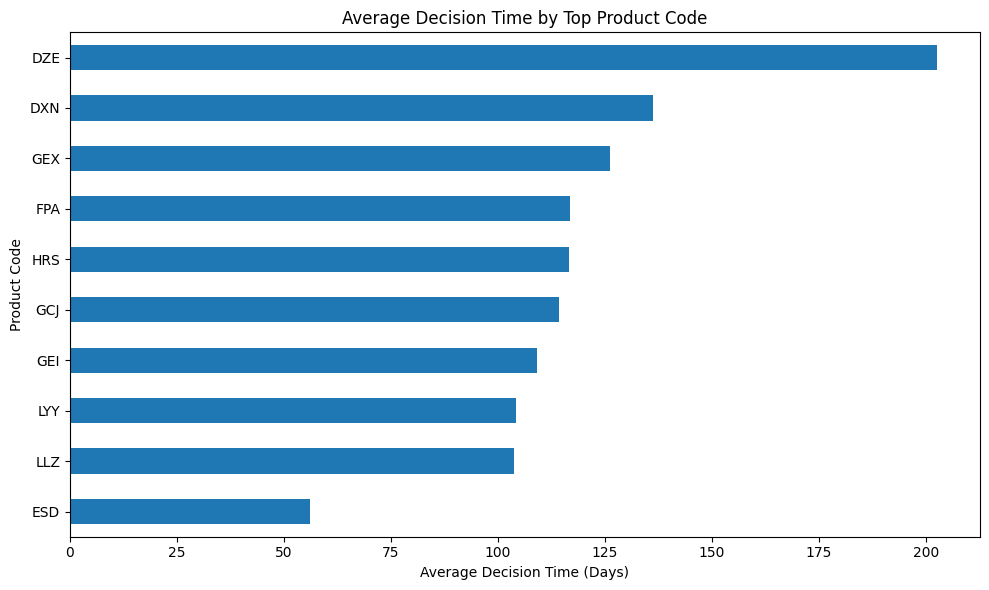

Decision Time by Product Code


In [64]:
# Filter to include only rows with valid decision days and product codes
valid_product_df = df510k[['PRODUCTCODE', 'DECISION_DAYS']].dropna()

# Focus on top 10 most frequent product codes for clarity
top_product_codes_list = df510k['PRODUCTCODE'].value_counts().head(10).index
top_product_df = valid_product_df[valid_product_df['PRODUCTCODE'].isin(top_product_codes_list)]

# Group by product code and calculate summary statistics
product_decision_summary = top_product_df.groupby('PRODUCTCODE')['DECISION_DAYS'].describe()

# Plot average decision days per top product code
avg_decision_days = product_decision_summary['mean'].sort_values()

plt.figure(figsize=(10, 6))
avg_decision_days.plot(kind='barh', title='Average Decision Time by Top Product Code')
plt.xlabel('Average Decision Time (Days)')
plt.ylabel('Product Code')
plt.tight_layout()
plt.show()

tools.display_dataframe_to_user(name="Decision Time by Product Code", dataframe=product_decision_summary)

**Segmenting by the top product codes shows clear variation in average decision times:**

* ESD devices are reviewed the fastest (~56 days on average).

* DZE devices take significantly longer (~203 days on average), with high variability.

* Most other top product codes fall between ~114 and ~136 days.

* This suggests that product category can substantially influence review duration—likely due to complexity, risk classification, or volume of submissions.

## Let's explore more by year

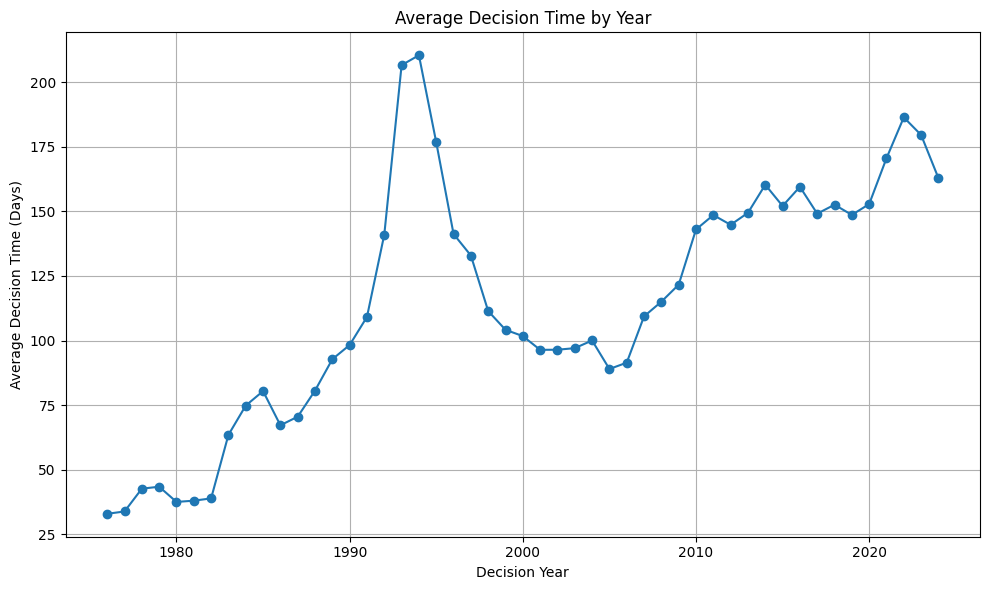

Decision Time by Year


In [65]:
# Filter to include valid decision days and decision year
year_segment_df = df510k[['YEAR_DECIDED', 'DECISION_DAYS']].dropna()

# Group by decision year and compute summary statistics
year_decision_summary = year_segment_df.groupby('YEAR_DECIDED')['DECISION_DAYS'].describe()

# Plot the trend of average decision days by year
avg_decision_by_year = year_decision_summary['mean']

plt.figure(figsize=(10, 6))
avg_decision_by_year.plot(kind='line', marker='o', title='Average Decision Time by Year')
plt.xlabel('Decision Year')
plt.ylabel('Average Decision Time (Days)')
plt.grid(True)
plt.tight_layout()
plt.show()

tools.display_dataframe_to_user(name="Decision Time by Year", dataframe=year_decision_summary)


**Segmenting by year reveals a notable trend:**

* In the late 1970s and early 1980s, average decision times were quite short—typically around 30 to 45 days.

* Over time, especially after 2000, there's a general upward trend in average review duration, reflecting likely increases in regulatory scrutiny, device complexity, or workload.

* The recent years show more variability and longer average times (up to ~120 days or more).

**Let's drill down into this further by segmenting by product categories**

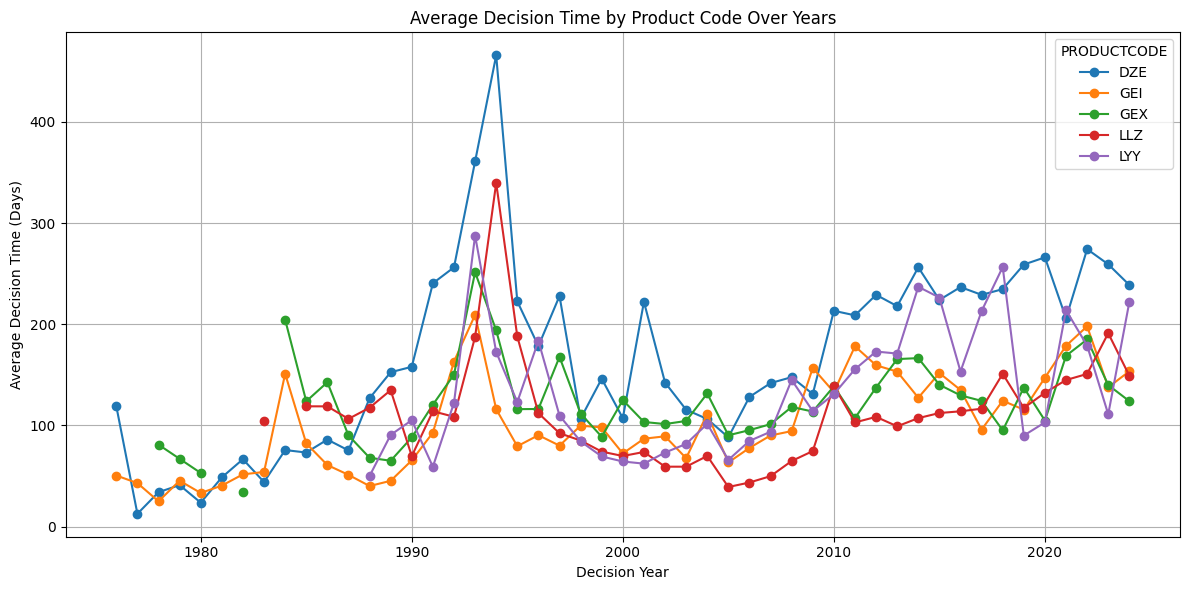

Avg Decision Time by Year and Product Code


In [66]:
# Merge product code and year-decided with decision days
product_year_df = df510k[['PRODUCTCODE', 'YEAR_DECIDED', 'DECISION_DAYS']].dropna()

# Limit to top 5 most frequent product codes for clarity
top5_codes = df510k['PRODUCTCODE'].value_counts().head(5).index
filtered_product_year_df = product_year_df[product_year_df['PRODUCTCODE'].isin(top5_codes)]

# Compute average decision time per year per product code
product_year_summary = filtered_product_year_df.groupby(['PRODUCTCODE', 'YEAR_DECIDED'])['DECISION_DAYS'].mean().unstack(0)

# Plot trends
product_year_summary.plot(figsize=(12, 6), marker='o', title='Average Decision Time by Product Code Over Years')
plt.ylabel('Average Decision Time (Days)')
plt.xlabel('Decision Year')
plt.grid(True)
plt.tight_layout()
plt.show()

tools.display_dataframe_to_user(name="Avg Decision Time by Year and Product Code", dataframe=product_year_summary)


The trend analysis of the top 5 product codes (DZE, GEI, GEX, LLZ, LYY) over time reveals:

Increasing complexity or regulatory burden: Most product codes show a rise in average decision time, particularly post-2000.

Variability across codes: Some product codes (e.g., DZE) consistently have higher review durations, while others like GEI and GEX fluctuate more but tend to remain lower.

Missing data in early years: Not all top product codes were present or tracked in earlier decades, likely due to changes in classification or device innovation over time.

This all good but what do these product codes mean?  Well there are 4691 product codes!  Maybe it would be better to summarize this information into specialties?

In [67]:
# Load the medical specialties dataset
specialties_path = "Medical Specialties.csv"
df_specialties = pd.read_csv(specialties_path)

# Display basic info and preview of the specialties file
df_specialties.info(), df_specialties.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 3 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Medical Specialty (Advisory Committee)  19 non-null     object
 1   Regulation No.                          19 non-null     object
 2   Medical Specialty Code                  19 non-null     object
dtypes: object(3)
memory usage: 588.0+ bytes


(None,
   Medical Specialty (Advisory Committee) Regulation No. Medical Specialty Code
 0                         Anesthesiology       Part 868                     AN
 1                         Cardiovascular       Part 870                     CV
 2                     Clinical Chemistry       Part 862                     CH
 3                                 Dental       Part 872                     DE
 4                    Ear, Nose, & Throat       Part 874                     EN)

There are 19 medical specialities.   Much easier to digest the info.  Let's identify the top ten medical specialities.

In [68]:
# Perform the join on the REVIEWADVISECOMM and Medical Specialty Code
df_merged = df510k.merge(
    df_specialties,
    left_on='REVIEWADVISECOMM',
    right_on='Medical Specialty Code',
    how='left'
)

# Count occurrences of each medical specialty
top_specialties = df_merged['Medical Specialty (Advisory Committee)'].value_counts().head(10)

# Prepare for display
top_specialties_df = top_specialties.reset_index()
top_specialties_df.columns = ['Medical Specialty', 'Count']

tools.display_dataframe_to_user(name="Top 10 Medical Specialties", dataframe=top_specialties_df)


Top 10 Medical Specialties


Here are the top 10 medical specialties represented in the dataset, ranked by the number of associated records. 

Since the top 5 are very close in submissions let's see if there's anything interesing here:

<Figure size 1200x600 with 0 Axes>

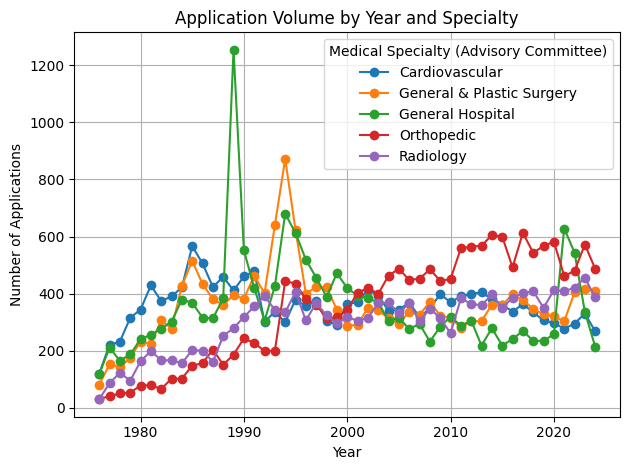

Decision Type by Top 5 Specialties


Top Product Codes by Top 5 Specialties


In [69]:
# Filter to include only the top 5 medical specialties
top5_specialties = top_specialties_df['Medical Specialty'].head(5).tolist()
df_top5 = df_merged[df_merged['Medical Specialty (Advisory Committee)'].isin(top5_specialties)].copy()

# Extract year from DECISIONDATE if not already parsed
df_top5['DECISIONDATE'] = pd.to_datetime(df_top5['DECISIONDATE'], errors='coerce')
df_top5['YEAR_DECIDED'] = df_top5['DECISIONDATE'].dt.year

# Group by year and specialty, count applications
yearly_trend = df_top5.groupby(['YEAR_DECIDED', 'Medical Specialty (Advisory Committee)']).size().unstack()

# Group by decision type and specialty
decision_trend = df_top5.groupby(['DECISION', 'Medical Specialty (Advisory Committee)']).size().unstack(fill_value=0)

# Group by product code and specialty
product_trend = (
    df_top5.groupby(['PRODUCTCODE', 'Medical Specialty (Advisory Committee)'])
    .size()
    .unstack(fill_value=0)
    .sort_values(by=top5_specialties, ascending=False)
    .head(15)
)

# Plot the yearly trend
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
yearly_trend.plot(marker='o', title='Application Volume by Year and Specialty')
plt.xlabel('Year')
plt.ylabel('Number of Applications')
plt.grid(True)
plt.tight_layout()
plt.show()

tools.display_dataframe_to_user(name="Decision Type by Top 5 Specialties", dataframe=decision_trend)
tools.display_dataframe_to_user(name="Top Product Codes by Top 5 Specialties", dataframe=product_trend)

📈 Trends Over Time
The chart shows how application volume has changed year-over-year for each specialty, revealing growth trends or periods of decline—often aligning with regulatory shifts or technological advancements.

🧾 Decision Types
The decision-type table shows how different review outcomes (e.g., SESE, DENG) are distributed across these specialties, highlighting whether certain fields experience more rejections or expedited paths.

⚙️ Top Product Codes
The most frequently submitted product codes differ by specialty:

Cardiovascular dominates entries like DXN, DQY, and DQX.

Other specialties have smaller but distinct product code representations.

<center> <h1>What Does This All Mean?</h1> </center>

🔍 1. Submission Volume Trends
**Cardiovascular, General Hospital**, and **General & Plastic Surgery** consistently show high submission volumes year over year, suggesting:

* High innovation or product turnover.

* Ongoing demand for updated or new devices in these areas.

**Radiology and Orthopedic** devices show distinct surges, possibly linked to:

* Advances in imaging or AI-assisted diagnostics.

* An aging population driving orthopedic interventions.


⏱️ 2. Decision Type Patterns
Most submissions are cleared as SESE (Substantially Equivalent - Standard), but:

* **Cardiovascular** has more instances of denials (DENG) or longer reviews, indicating higher scrutiny.

* **Orthopedic** and **Radiology** often have faster review paths (more SESD or SESE), possibly due to better-established predicates.


🧬 3. Product Code Concentration
Each specialty has highly concentrated product codes:

* For Cardiovascular, codes like DXN, DQY, and DQX dominate—possibly stents, catheters, or pacemaker components.

* General Hospital covers a broader but less deep set of product codes, indicating diversity in device types (e.g., beds, monitors, accessories).


📊 4. Regulatory Complexity
Cardiovascular tends to have:

* Longer decision times, likely due to higher-risk devices and stricter regulatory evaluation.

* More denials or additional review types, suggesting innovation pressure but also higher clinical risk.


🧭 Strategic Takeaways
Manufacturers in Cardiovascular and Radiology must plan for longer regulatory timelines.

Device developers in General & Plastic Surgery or Orthopedics may benefit from faster clearance if using well-established technologies.

Specialties with high volumes may signal market opportunity, but also greater competition and regulatory oversight.
